# 🎓 Student Placement Intelligence System  
### Machine Learning Based Placement Prediction & Risk Analysis  

---
## 📌 Problem Statement  
The objective of this project is to develop a machine learning model that predicts whether a student will be placed or not based on academic performance, technical skills, internships, and extracurricular activities.  
The system also provides probability-based risk scoring to help institutions identify students who require early intervention and skill development support.

---

In [1]:
#STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc
from xgboost import XGBClassifier, XGBRegressor

In [2]:
#STEP 2: Load Dataset
df = pd.read_csv("placementdata.csv")
df.head()

,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


In [3]:
#STEP 3: Basic Exploration
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  10000 non-null  int64  
 1   CGPA                       10000 non-null  float64
 2   Internships                10000 non-null  int64  
 3   Projects                   10000 non-null  int64  
 4   Workshops/Certifications   10000 non-null  int64  
 5   AptitudeTestScore          10000 non-null  int64  
 6   SoftSkillsRating           10000 non-null  float64
 7   ExtracurricularActivities  10000 non-null  object 
 8   PlacementTraining          10000 non-null  object 
 9   SSC_Marks                  10000 non-null  int64  
 10  HSC_Marks                  10000 non-null  int64  
 11  PlacementStatus            10000 non-null  object 
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


StudentID                    0
CGPA                         0
Internships                  0
Projects                     0
Workshops/Certifications     0
AptitudeTestScore            0
SoftSkillsRating             0
ExtracurricularActivities    0
PlacementTraining            0
SSC_Marks                    0
HSC_Marks                    0
PlacementStatus              0
dtype: int64

In [4]:
#STEP 4: Drop Unnecessary Column
df = df.drop("StudentID", axis=1)

In [5]:
#STEP 5: Convert Target to Binary
df["PlacementStatus"].unique()
df["PlacementStatus"] = df["PlacementStatus"].map({"Placed":1, "NotPlaced":0})

In [6]:
#STEP 6: Feature Engineering
df["Academic_Performance"] = (df["SSC_Marks"] + df["HSC_Marks"] + df["CGPA"]*10) / 3
df["Skill_Index"] = (
    df["AptitudeTestScore"] +
    df["SoftSkillsRating"]*20 +
    df["Projects"]*5
) / 3
df["Profile_Strength"] = df["Internships"] + df["Workshops/Certifications"]

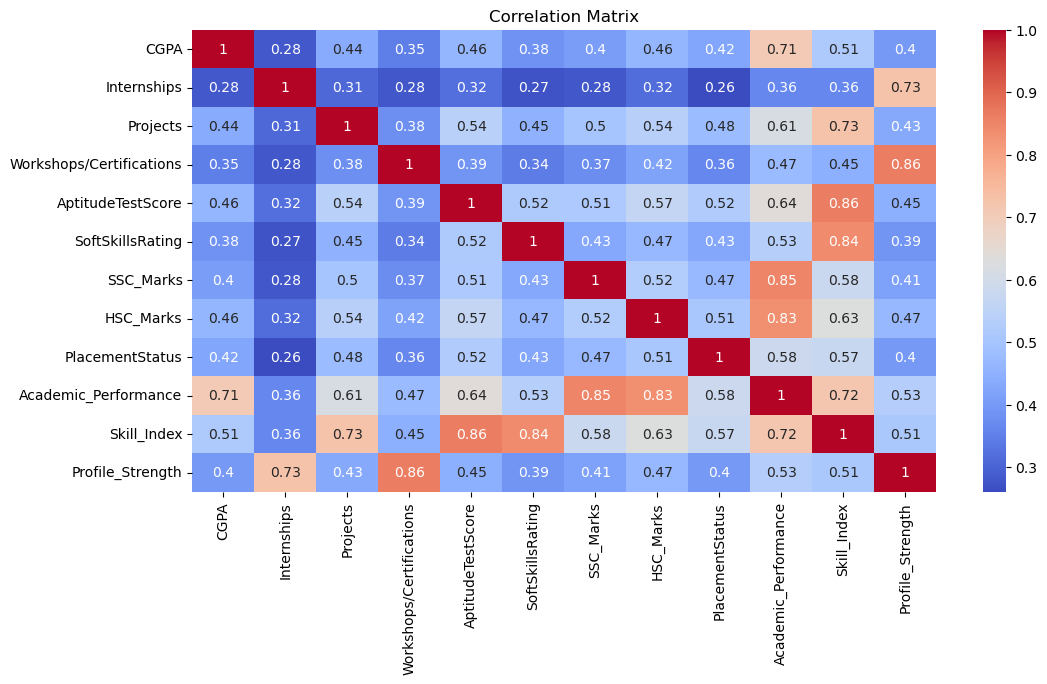

In [7]:
#STEP 7: Correlation Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [8]:
#STEP 8: Define Features and Target
y = df["PlacementStatus"]
X = df.drop("PlacementStatus", axis=1)

In [9]:
#STEP 9: Preprocessing Pipeline
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])

In [10]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
#STEP 11: Train Baseline Models
models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss")
}
results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds)
    }

pd.DataFrame(results).T

,Accuracy,F1 Score
Logistic,0.7945,0.755503
RandomForest,0.7875,0.736516
XGBoost,0.7805,0.734101


In [12]:
#STEP 12: Cross Validation
rf_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier())
])
cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring="f1")
print("Average F1 Score:", cv_scores.mean())

Average F1 Score: 0.7360372586739994


In [13]:
#STEP 13: Hyperparameter Tuning
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10]
}
grid = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring="f1")
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

Best Parameters: {'model__max_depth': 5, 'model__n_estimators': 200}


In [14]:
#STEP 14: Evaluate Best Model
best_model = grid.best_estimator_
preds = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print("F1 Score:", f1_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))

Accuracy: 0.79
F1 Score: 0.7423312883435583

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1172
           1       0.75      0.73      0.74       828

    accuracy                           0.79      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.79      0.79      0.79      2000



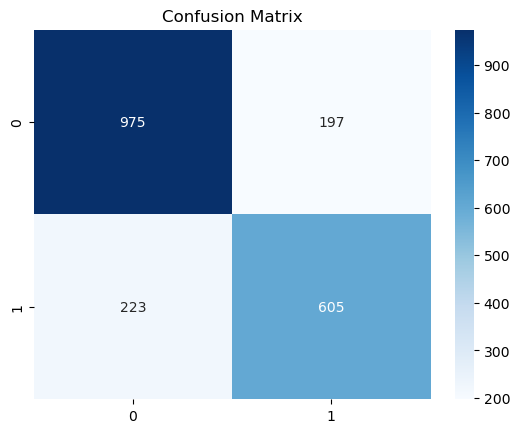

In [15]:
#STEP 15: Confusion Matrix
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

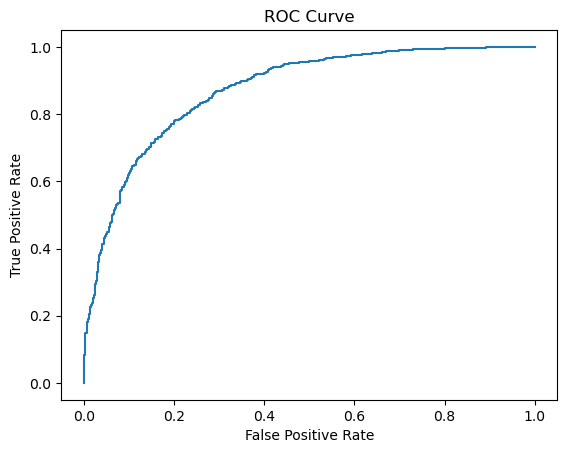

In [16]:
#STEP 16: ROC Curve
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [17]:
#STEP 17: Placement Risk Scoring
df["Placement_Probability"] = best_model.predict_proba(X)[:,1]
df[["Placement_Probability"]].head()

,Placement_Probability
0,0.125384
1,0.767843
2,0.524816
3,0.575912
4,0.756651


In [18]:
#Create a New Student Data
new_student = pd.DataFrame({
    "CGPA": [8.2],
    "Internships": [2],
    "Projects": [4],
    "Workshops/Certifications": [3],
    "AptitudeTestScore": [78],
    "SoftSkillsRating": [4.2],
    "ExtracurricularActivities": ["Yes"],
    "PlacementTraining": ["Yes"],
    "SSC_Marks": [88],
    "HSC_Marks": [85]
})

In [19]:
new_student["Academic_Performance"] = (88 + 85 + 8.2*10) / 3

new_student["Skill_Index"] = (
    78 + 4.2*20 + 4*5
) / 3

new_student["Profile_Strength"] = 2 + 3


In [20]:
prediction = best_model.predict(new_student)
probability = best_model.predict_proba(new_student)

print("Prediction:", prediction)
print("Placement Probability:", probability[:,1])

Prediction: [1]
Placement Probability: [0.67627906]


In [21]:
#Student Likely NOT Placed
new_student_low = pd.DataFrame({
    "CGPA": [6.1],
    "Internships": [0],
    "Projects": [1],
    "Workshops/Certifications": [0],
    "AptitudeTestScore": [45],
    "SoftSkillsRating": [2.5],
    "ExtracurricularActivities": ["No"],
    "PlacementTraining": ["No"],
    "SSC_Marks": [60],
    "HSC_Marks": [58]
})


In [23]:
new_student_low["Academic_Performance"] = (60 + 58 + 6.1*10) / 3

new_student_low["Skill_Index"] = (
    45 + 2.5*20 + 1*5
) / 3

new_student_low["Profile_Strength"] = 0 + 0


In [24]:
prediction_low = best_model.predict(new_student_low)
probability_low = best_model.predict_proba(new_student_low)

print("Prediction:", prediction_low)
print("Placement Probability:", probability_low[:,1])


Prediction: [0]
Placement Probability: [0.04676528]
